# FIN270A Final Project
### Siying Chen

In [17]:
# %pip install yfinance
# %pip install networkx
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx

### Load data, calculate variables

In [18]:
ticker = 'LULU'
start_date = '2022-12-01'
end_date = '2024-12-04'
maturity_date = '2024-12-27'
end_date_obj = datetime.strptime(end_date, '%Y-%m-%d')
maturity_date_obj = datetime.strptime(maturity_date, '%Y-%m-%d')
days_diff = (maturity_date_obj - end_date_obj).days
latest_close_price = 0
n = 252
S0 = latest_close_price
K = 340
r = 0.0476 # risk-free rate, As of November 29, 2024, the 1-month U.S. Treasury bill yield is approximately 4.76%
u = 1.1
d = 0.9
T = days_diff/n
dt = 1/52
market_price = 21.00 # Market price of the call option for K = 340


# Download historical data from Yahoo Finance
data = yf.download(ticker, start=start_date, end=end_date)
df = pd.DataFrame(data)

# Logarithmic daily return
df['U_i'] = np.log(df['Adj Close'] / df['Adj Close'].shift(1))
# Average of U_i
U_Av = df['U_i'].mean()
# (U_i - U_Av)^2
df['(U_i - U_Av)^2'] = (df['U_i'] - U_Av) ** 2
# U_i^2
df['U_i^2'] = df['U_i'] ** 2

# Drop NaN rows (due to the shift operation)
df = df.dropna()
n = len(df)
latest_close_price = df['Adj Close'].iloc[-1]
S0 = latest_close_price

# Display the DataFrame
display = ['Adj Close', 'U_i', '(U_i - U_Av)^2']
print(df[display])
print(f"n: {n}")

# Annualized volatility, population standard deviation
annual_vol_p = np.sqrt(sum(df['(U_i - U_Av)^2']) / n) * np.sqrt(n)
print(f"Annualized Volatility population standard deviation: {annual_vol_p*100:.4f}%")

# Annualized volatility, sample standard deviation
annual_vol_s = np.sqrt(sum(df['(U_i - U_Av)^2']) / (n-1)) * np.sqrt(n)
print(f"Annualized Volatility sample standard deviation: {annual_vol_s*100:.4f}%")

# Pandas Sample standard deviation
daily_vol_pandas = df['U_i'].std()
annual_vol_pandas = daily_vol_pandas * np.sqrt(n)
print(f"Annualized Volatility (Pandas): {annual_vol_pandas:.4%}")

verification = np.isclose(annual_vol_s, annual_vol_pandas, atol=1e-10)
print(f"Verification: {verification}")

# Save to CSV (optional)
# data[['Adj Close', 'Daily Return']].dropna().to_csv(f"{ticker}_daily_returns.csv")

[*********************100%%**********************]  1 of 1 completed

             Adj Close       U_i  (U_i - U_Av)^2
Date                                            
2022-12-02  385.989990  0.010862        0.000123
2022-12-05  381.130005 -0.012671        0.000155
2022-12-06  370.000000 -0.029638        0.000865
2022-12-07  372.329987  0.006278        0.000042
2022-12-08  374.510010  0.005838        0.000037
...                ...       ...             ...
2024-11-26  318.839996 -0.024414        0.000585
2024-11-27  319.519989  0.002130        0.000006
2024-11-29  320.660004  0.003562        0.000014
2024-12-02  334.399994  0.041956        0.001779
2024-12-03  340.660004  0.018547        0.000352

[503 rows x 3 columns]
n: 503
Annualized Volatility population standard deviation: 50.4670%
Annualized Volatility sample standard deviation: 50.5173%
Annualized Volatility (Pandas): 50.5173%
Verification: True


### Black Scholes Model

In [19]:
def black_scholes(S0, K, r, T, sigma, option_type):
    """
    Parameters:
    S0 (float): Current price of the underlying asset
    K (float): Strike price of the option
    r (float): Risk-free interest rate (annualized)
    T (float): Time to maturity of the option in years
    sigma (float): Volatility of the underlying asset (annualized)
    option_type (str): 'call' or 'put'
    
    Returns:
    float: Option price, N(d1), and N(d2)
    """
    d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    # print("d1:", d1)
    # print("d2:", d2)
    
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)
    
    if option_type.lower() == 'call':
        option_price = S0 * N_d1 - K * np.exp(-r * T) * N_d2
    elif option_type.lower() == 'put':
        option_price = K * np.exp(-r * T) * (1 - N_d2) - S0 * (1 - N_d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'.")

    return option_price, N_d1, N_d2

In [20]:
print(S0, K, r, T, annual_vol_pandas)
option_price_bsm, N_d1, N_d2 = black_scholes(S0 = S0, K = K, r = r, T= T, sigma = annual_vol_pandas, option_type = 'call')
print(f"Estimated call option price based on Black Scholes Model: {option_price_bsm:.2f}")

340.6600036621094 340 0.0476 0.09126984126984126 0.5051728947999866
Estimated call option price based on Black Scholes Model: 21.74


### Binomial Tree Model

In [21]:
def cal_u_d(volatility):
    '''
        u (upward price multiplier) and d (downward price multiplier)
    '''
    u = np.exp(volatility * np.sqrt(dt))
    d = 1/u
    
    return u,d

In [22]:
def plot_binomial_tree_call(S0, S, C, N):
    """
    Plot Binomial Tree Diagram using NetworkX with organized layout.
    """
    G = nx.DiGraph()
    pos = {}  # Custom position dictionary

    node_labels = {}
    value_labels = {}
    
    node_count = 0
    x_spacing = 2.0
    y_spacing = 1.0
    
    for i in range(N + 1):
        level_nodes = [(j, S[i,j]) for j in range(i + 1)]
        level_nodes.sort(key=lambda x: x[1], reverse=True)
        
        # Add nodes for this level
        y_offset = (len(level_nodes) - 1) * y_spacing / 2
        for idx, (j, price) in enumerate(level_nodes):
            G.add_node(node_count)
            
            pos[node_count] = (i * x_spacing, y_offset - idx * y_spacing)
            
            node_labels[node_count] = f"{node_count}"
            value_labels[node_count] = f"S={S[i,j]:.2f}\nC={C[i,j]:.2f}"
            
            if i < N:
                if j < i + 1:
                    G.add_edge(node_count, node_count + i + 1)
                    G.add_edge(node_count, node_count + i + 2)
            
            node_count += 1

    plt.figure(figsize=(15, 10))
    nx.draw(G, pos,
            labels=node_labels,
            with_labels=True,
            node_color='#003777',
            node_size=1500,
            font_color='white',
            font_size=12,
            arrows=True,
            edge_color='#003777',
            arrowsize=20)
    
    # Add value labels
    for node, (x, y) in pos.items():
        plt.text(x, y-0.3, value_labels[node],
                horizontalalignment='center',
                color='#3B3838',
                fontsize=10)

    plt.title(f"Binary Tree for Option Pricing (S0 = {S0:.2f})",
             fontsize=14,
             pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [23]:
def binomial_tree_call(S0, K, r, T, dt, u, d, plotSwitch):
    """
    Parameters:
    S0 (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate
    T (float): Time to maturity in years
    dT (float): Time Step in years
    u (float): Upward price multiplier
    d (float): Downward price multiplier

    Returns:
    float: Option price
    """
    
    N = int(T / dt)  # Number of time steps
    p = (np.exp(r * dt) - d) / (u - d)  # Upward probability
    q = 1 - p  # Downward probability
    discount_factor = np.exp(-r * dt)
    # print("p", p)
    # print("q", q)

    S = np.zeros((N+1, N+1))
    C = np.zeros((N+1, N+1))
    
    # Stock prices
    for i in range(N+1):
        for j in range(i+1):
            S[i, j] = S0 * (u ** (i-j)) * (d ** j)
    
    # Option prices
    for j in range(N+1):
        C[N, j] = max(S[N, j] - K, 0) if S[N, j] > K else 0
    
    # Backward induction for option prices
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            C[i, j] = discount_factor * (p * C[i+1, j] + q * C[i+1, j+1])
    
    # print("inputs: ", S0, K, r, T, dt, u, d)
    # print("p: ", p)
    # print("stock prices: ", S)
    # print("option prices: ", C)
    # print("discount_factor: ", discount_factor)
    # print("N: ", N)

    if plotSwitch:
        plot_binomial_tree_call(S0, S, C, N)
    
    return S, C

    # Print final deltas
    # print(f"Deltas: {delta_tree}")



C:\Users\WENDY CHEN\AppData\Local\Temp\ipykernel_27704\1959283726.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


340.6600036621094 340 0.0476 0.09126984126984126 0.5051728947999866 0.019230769230769232 1.0725670377940677 0.932342655296106


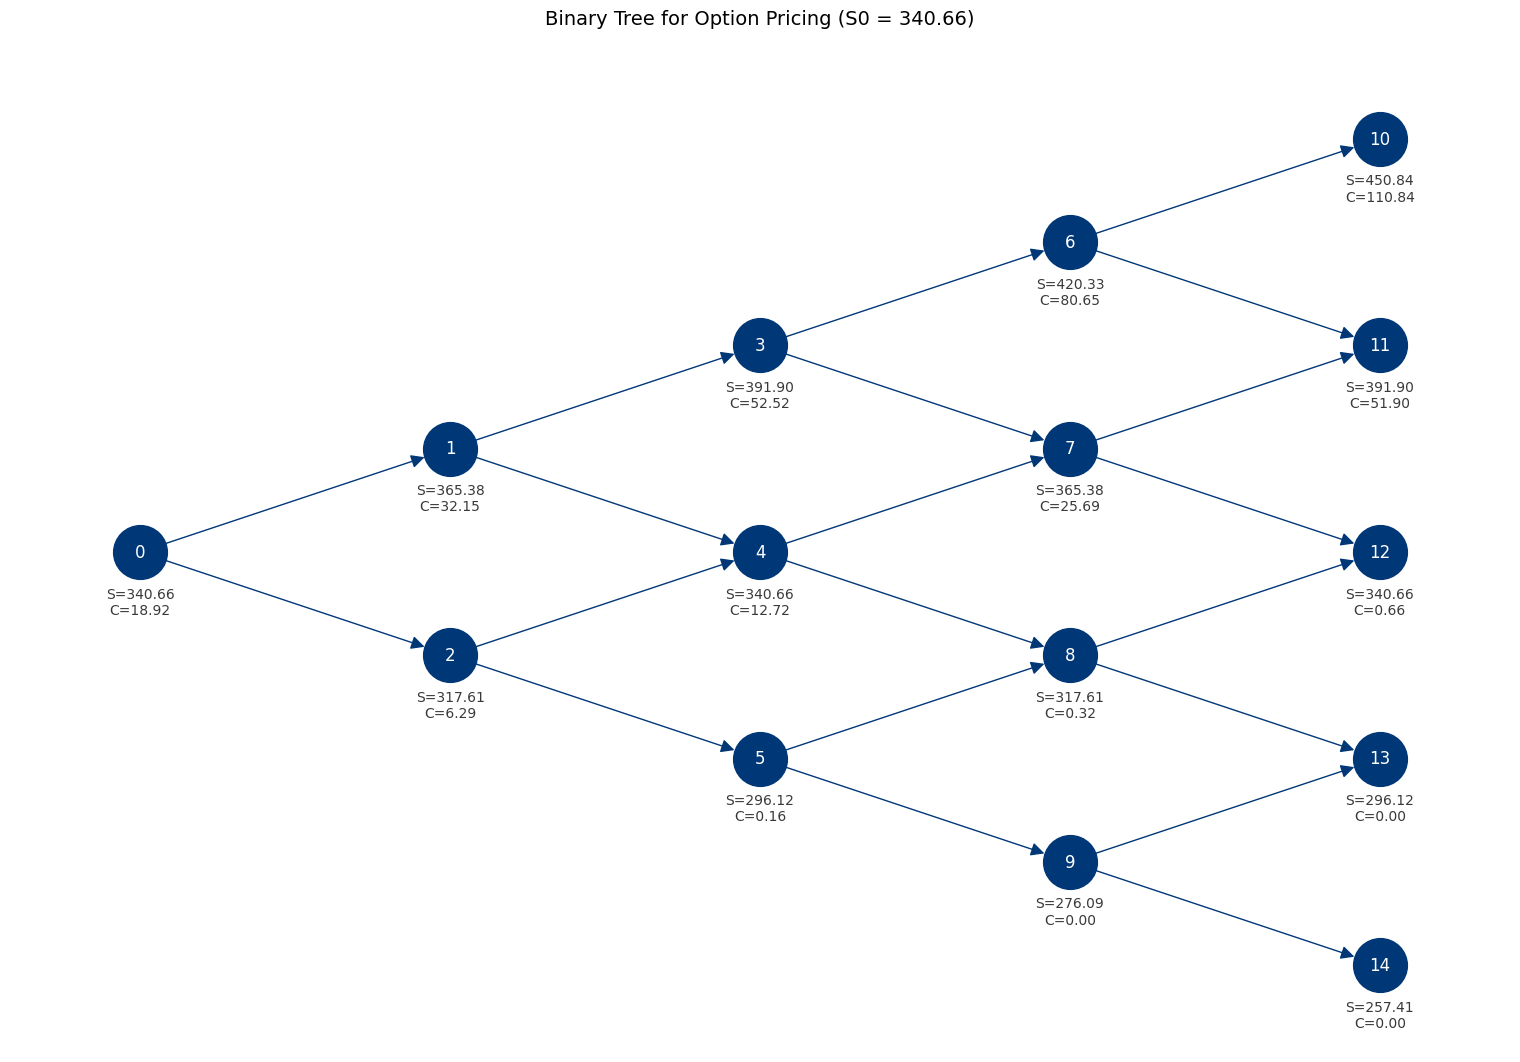

Estimated call option price based on Binomial Tree Model: 18.92


In [24]:
u, d = cal_u_d(annual_vol_pandas)
print(S0, K, r, T, annual_vol_pandas, dt, u, d)
stock_price_btm, option_price_btm = binomial_tree_call(S0, K, r, T, dt, u, d, True)
print(f"Estimated call option price based on Binomial Tree Model: {option_price_btm[0,0]:.2f}")

### Implied volatility

In [25]:
def implied_volatility(S0, K, r, T, market_price, option_type='call'):
    """
    Calculate implied volatility using the Black-Scholes-Merton model.

    Parameters:
    S0 (float): Current stock price
    K (float): Strike price
    r (float): Risk-free interest rate
    T (float): Time to maturity in years
    market_price (float): Observed market price of the option
    option_type (str): 'call' or 'put'

    Returns:
    float: Implied volatility
    """
    def objective_function(sigma):
        # Compute the difference between BSM price and market price
        bs_price, _, _ = black_scholes(S0, K, r, T, sigma, option_type)
        return (bs_price - market_price) ** 2  # Minimize squared error

    # Initial guess for volatility
    initial_sigma = annual_vol_pandas
    result = minimize(objective_function, initial_sigma, bounds=[(0.001, 5.0)])
    return result.x[0] if result.success else None


In [26]:
implied_vol = implied_volatility(S0 = S0, K = K, r = r, T = T, market_price = market_price, option_type='call')
print(f"Implied Volatility: {implied_vol:.4f}")

Implied Volatility: 0.4870


### Models with Implied Volatility

In [27]:
print(S0, K, r, T, annual_vol_pandas)
option_price_bsm_imp, N_d1_imp, N_d2_imp = black_scholes(S0 = S0, K = K, r = r, T= T, sigma = implied_vol, option_type = 'call')
print("Estimated call option price based on implied Volatility:", option_price_bsm_imp)

340.6600036621094 340 0.0476 0.09126984126984126 0.5051728947999866
Estimated call option price based on implied Volatility: 20.999999808869802


In [28]:
u_imp, d_imp = cal_u_d(implied_vol)
print(S0, K, r, T, implied_vol, dt, u_imp, d_imp)
stock_price_btm_imp, option_price_btm_imp = binomial_tree_call(S0, K, r, T, dt, u_imp, d_imp, False)
print(f"Estimated call option price based on Binomial Tree Model: {option_price_btm_imp[0,0]:.2f}")

340.6600036621094 340 0.0476 0.09126984126984126 0.4870096619477794 0.019230769230769232 1.0698688691436715 0.9346939880589339
Estimated call option price based on Binomial Tree Model: 18.28


### Conclusion(1 week time step)

In [29]:
print(f"""
Comparison of Models:
- Estimated call option price based on Black Scholes Model: {option_price_bsm:.2f}
- Estimated call option price based on Binomial Tree Model: {option_price_btm[0,0]:.2f}
- Estimated call option price based on Black Scholes Model(implied volatility): {option_price_bsm_imp:.2f}
- Estimated call option price based on Binomial Tree Model(implied volatility): {option_price_btm_imp[0,0]:.2f}
""")


Comparison of Models:
- Estimated call option price based on Black Scholes Model: 21.74
- Estimated call option price based on Binomial Tree Model: 18.92
- Estimated call option price based on Black Scholes Model(implied volatility): 21.00
- Estimated call option price based on Binomial Tree Model(implied volatility): 18.28



### Conclusion(1 day time step)

In [30]:
dt = 1/252
u, d = cal_u_d(annual_vol_pandas)
# print(u,d)
option_price_bsm, N_d1, N_d2 = black_scholes(S0 = S0, K = K, r = r, T= T, sigma = annual_vol_pandas, option_type = 'call')
stock_price_btm, option_price_btm = binomial_tree_call(S0, K, r, T, dt, u, d, False)

In [31]:
print(f"""
Comparison of Models:
- Estimated call option price based on Black Scholes Model: {option_price_bsm:.2f}
- Estimated call option price based on Binomial Tree Model: {option_price_btm[0,0]:.2f}
""")


Comparison of Models:
- Estimated call option price based on Black Scholes Model: 21.74
- Estimated call option price based on Binomial Tree Model: 21.96

